In [2]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error as mse

import bbDebiasing as bbDebias
import maxEnsembleDebias as maxDebias
import policies

# Bias Bounties Style Updates

In [489]:
importlib.reload(bbDebias)
importlib.reload(policies)

xs = np.array([[1],[2],[3]]) 
ys = np.array([[1,10], [2,1], [4,0]])

def h0(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([3.,9.])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([1,0])
    return np.array(preds)

def h1(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([1.,0.])
        if x==2:
            preds.append([0,1])
        if x==3:
            preds.append([0,1])
    return np.array(preds)

def h2(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([0.,1.])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([0,1])
    return np.array(preds)

def h3(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([0.,1.])
        if x==2:
            preds.append([0,1])
        if x==3:
            preds.append([1,0])
    return np.array(preds)

max_depth = 20
pred_dim = 2
policy0 = policies.Simplex(pred_dim, h0)
policy1 = policies.Simplex(pred_dim, h1)
policy2 = policies.Simplex(pred_dim, h2)
policy3 = policies.Simplex(pred_dim, h3)

max_depth = 40
tolerance = 0.1 # after MSE improvement drops below this, halt debiasing process
model = bbDebias.bbDebias(h0, policy0, xs, ys, max_depth, tolerance)

model.debias([h1,h2,h3],[policy1,policy2,policy3])

Hit tolerance; halting debiasing.


Text(0.5, 1.0, 'BB Alg: MSE over Rounds, by Policy')

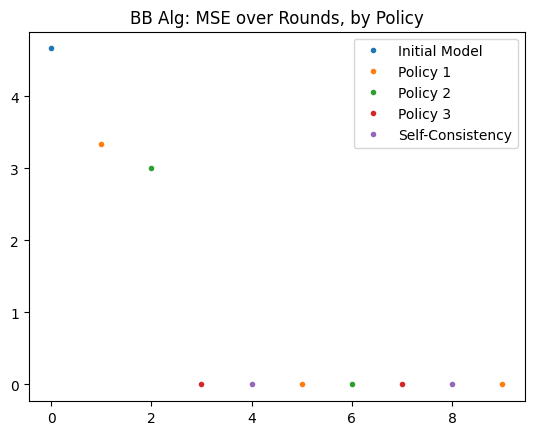

In [490]:
# generate MSE for each round 

mses = np.array([mse(ys, pred, multioutput='raw_values') for pred in model.predictions_by_round])

coord = 0
plt.plot(0,mses[0][coord],'.', label="Initial Model")
for i in range(1, model.n_models+1):
    indices = list(range(len(model.predictions_by_round)))[i::(model.n_models + 1)]
    plt.plot(indices, mses[i::(model.n_models + 1)][:, coord], '.', label=f"Policy {i}")
indices = list(range(len(model.predictions_by_round)))[(model.n_models+1)::(model.n_models + 1)]
plt.plot(indices, mses[(model.n_models+1)::(model.n_models + 1)][:, coord], '.', label="Self-Consistency")
plt.legend()
plt.title("BB Alg: MSE over Rounds, by Policy")

Text(0.5, 1.0, 'BB Alg: Predicted and Realized Revenue over Rounds')

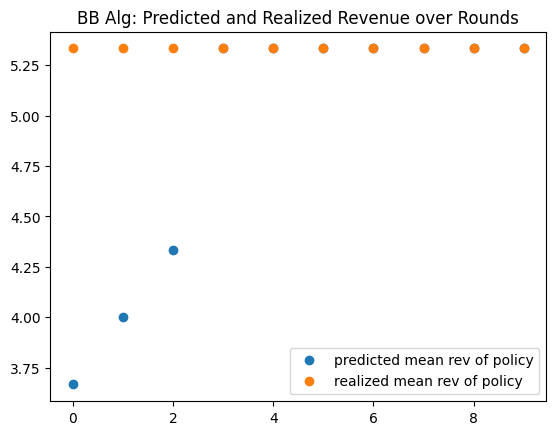

In [491]:
# predicted revenue of each point per round
pred_rev = [np.einsum('ij,ij->i', model.predictions_by_round[i], policy0.run_given_preds(model.predictions_by_round[i])) for i in range(len(model.predictions_by_round))] #fancy vectorized row-wise dot product 
# realized revenue
true_rev = [np.einsum('ij,ij->i', ys, policy0.run_given_preds(model.predictions_by_round[i])) for i in range(len(model.predictions_by_round))]


plt.plot(range(len(model.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean rev of policy")
plt.plot(range(len(model.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean rev of policy")
plt.legend()
plt.title("BB Alg: Predicted and Realized Revenue over Rounds")

# Max Ensemble Approach

In [492]:
importlib.reload(maxDebias)
importlib.reload(policies)

xs = np.array([[1],[2],[3]]) 
ys = np.array([[1,10], [2,1], [4,0]])
pred_dim = 2

def h0(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([3.,9.])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([1,0])
    return np.array(preds)

def h1(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([1.,0.])
        if x==2:
            preds.append([0,10])
        if x==3:
            preds.append([0,2])
    return np.array(preds)

policy0 = policies.Simplex(pred_dim, h0)
policy1 = policies.Simplex(pred_dim, h1)


model = maxDebias.EnsembledModel([h0,h1], [policy0, policy1], xs, ys, 5, 0.1)
model.debias()
out, transcript = model.predict(xs)


Maximum depth reached.


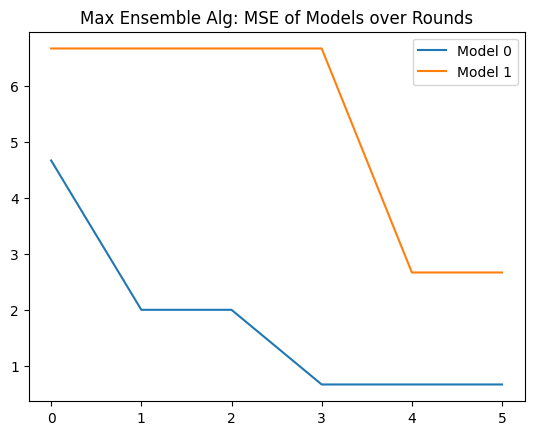

In [493]:
preds = np.array(model.predictions_by_round)

preds_by_model = [preds[:,i] for i in range(model.n_models)]
mses_by_model = np.zeros((len(preds_by_model), len(preds), model.pred_dim))
for i in range(model.n_models):
    for j in range(len(preds_by_model[i])):
        mses_by_model[i][j] = mse(ys, preds_by_model[i][j], multioutput='raw_values')

coord = 0
for i in range(model.n_models):
    plt.plot(np.arange(len(model.predictions_by_round)), mses_by_model[i][:,coord], label=f"Model {i}")
plt.legend()
plt.title("Max Ensemble Alg: MSE of Models over Rounds");

Text(0.5, 1.0, 'Max Ensemble Alg: Average Predicted and Realized Revenue of Policies')

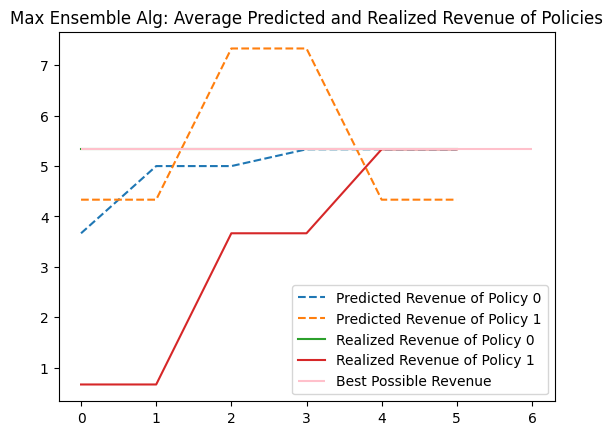

In [494]:
pred_rev = [[np.mean(np.einsum('ij, ij->i', preds_by_model[i][j], model.policies[i].run_given_preds(preds_by_model[i][j]))) for j in range(len(preds_by_model[i]))] for i in range(model.n_models)]
realized_rev = [[np.mean(np.einsum('ij, ij->i', ys, model.policies[i].run_given_preds(preds_by_model[i][j]))) for j in range(len(preds_by_model[i]))] for i in range(model.n_models)]

n = len(model.predictions_by_round)
for i in range(model.n_models):
    plt.plot(np.arange(n), pred_rev[i], '--', label=f"Predicted Revenue of Policy {i}")
for i in range(model.n_models):
    plt.plot(np.arange(n), realized_rev[i], label=f"Realized Revenue of Policy {i}")

plt.hlines(np.mean(np.einsum('ij, ij->i', ys, model.policies[0].run_given_preds(ys))), 0, n, label="Best Possible Revenue", color='pink')
plt.legend()
plt.title("Max Ensemble Alg: Average Predicted and Realized Revenue of Policies")

In [498]:
len(model.predictions_by_round)

6

In [497]:
len(model.meta_model_pred_by_round)

5

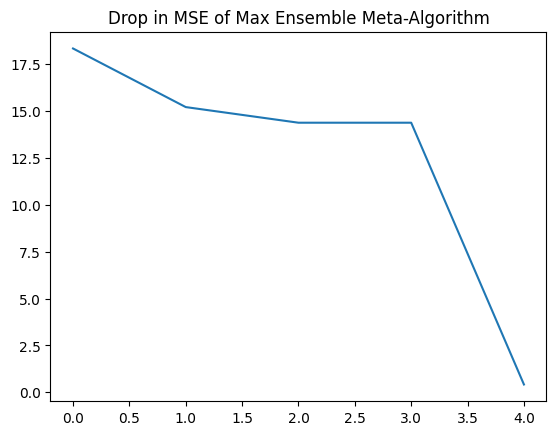

In [495]:
ensemble_mse = np.array([mse(ys, model.meta_model_pred_by_round[i]) for i in range(len(model.meta_model_pred_by_round))])
coord = 0

plt.plot(np.arange(len(ensemble_mse)), ensemble_mse)
plt.title("Drop in MSE of Max Ensemble Meta-Algorithm")
plt.savefig('meta-algMSE.png')

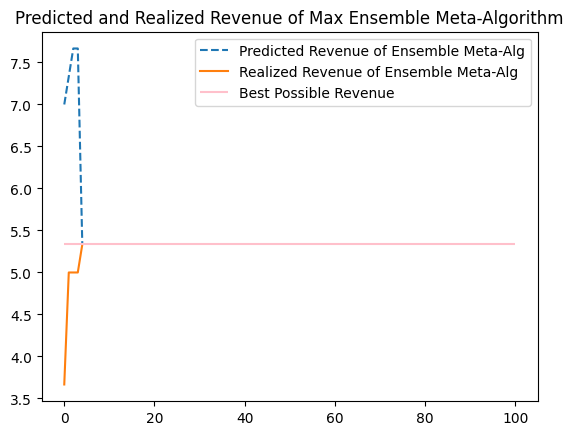

In [496]:
pred_rev = [np.mean(np.einsum('ij, ij->i', model.meta_model_pred_by_round[i], model.meta_policy_choice_by_round[i])) for i in range(len(model.meta_model_pred_by_round))]
realized_rev = [np.mean(np.einsum('ij, ij->i', ys, model.meta_policy_choice_by_round[i])) for i in range(len(model.meta_model_pred_by_round))] 

plt.plot(np.arange(len(model.meta_model_pred_by_round)), pred_rev, '--', label="Predicted Revenue of Ensemble Meta-Alg")
plt.plot(np.arange(len(model.meta_model_pred_by_round)), realized_rev, label="Realized Revenue of Ensemble Meta-Alg")
plt.hlines(np.mean(np.einsum('ij, ij->i', ys, model.policies[0].run_given_preds(ys))), 0, 100, label="Best Possible Revenue", color='pink')
plt.legend()
plt.title("Predicted and Realized Revenue of Max Ensemble Meta-Algorithm");
plt.savefig("meta-algRev.png")

# Synthetic Linear Data Experiments

Data Generation

In [4]:
n = 50
n_features = 6
pred_dim = 6

np.random.seed(30)

# Gaussian xs, with true labels having a different linear relationship with xs in each coordinate
xs = np.random.normal(size=(n, n_features))
slopes = np.random.uniform(size = n_features)
#errs = np.random.normal(scale=0.01, size = (n, n_features))
ys = np.multiply(xs, slopes) #+ errs

# series of models which each predict the correct linear relationship in one coordinate and mean on other coordinates

def meta_model(coord, slopes):
    def model(xs):
        preds = np.zeros((len(xs), n_features), dtype='float64')
        true_ys = np.multiply(xs, slopes)
        preds[:,coord] = true_ys[:,coord]
        return preds
    return model

n_models = 6
all_models = []
all_policies = []

for i in range(n_models):
    model = meta_model(i, slopes)
    all_models.append(model)
    all_policies.append(policies.Simplex(pred_dim, model))

# model which predicts 0 everywhere
def init_model(xs):
    preds = np.zeros((len(xs), n_features), dtype='float64')
    return preds

init_policy = policies.Simplex(pred_dim, init_model)

Running on Bias Bounties Method

In [7]:
max_depth = 1000
tolerance = 0.01

bbModel = bbDebias.bbDebias(init_model, init_policy, xs, ys, max_depth, tolerance)
bbModel.debias(all_models, all_policies)

Hit tolerance; halting debiasing.


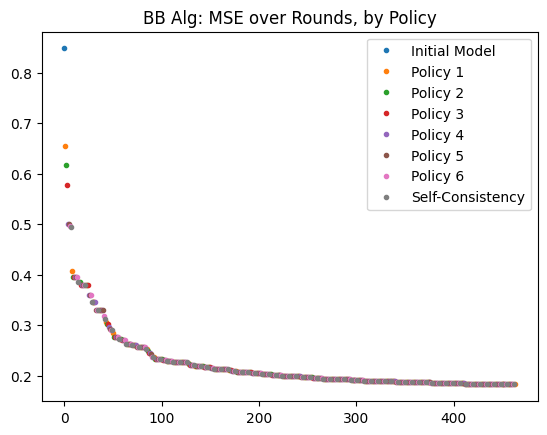

In [8]:
mses = np.array([mse(ys, pred, multioutput='raw_values') for pred in bbModel.predictions_by_round])

coord = 0
plt.plot(0,mses[0][coord],'.', label="Initial Model")
for i in range(1, bbModel.n_models+1):
    indices = list(range(len(bbModel.predictions_by_round)))[i::(bbModel.n_models + 1)]
    plt.plot(indices, mses[i::(bbModel.n_models + 1)][:, coord], '.', label=f"Policy {i}")
indices = list(range(len(bbModel.predictions_by_round)))[(bbModel.n_models+1)::(bbModel.n_models + 1)]
plt.plot(indices, mses[(bbModel.n_models+1)::(bbModel.n_models + 1)][:, coord], '.', label="Self-Consistency")
plt.legend()
plt.title("BB Alg: MSE over Rounds, by Policy");

Text(0.5, 1.0, 'BB Alg: Predicted and Realized Revenue over Rounds')

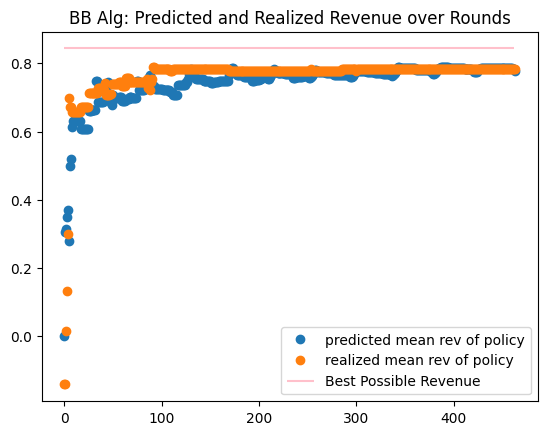

In [9]:
# predicted revenue of each point per round
pred_rev = [np.einsum('ij,ij->i', bbModel.predictions_by_round[i], init_policy.run_given_preds(bbModel.predictions_by_round[i])) for i in range(len(bbModel.predictions_by_round))] #fancy vectorized row-wise dot product 
# realized revenue
true_rev = [np.einsum('ij,ij->i', ys, init_policy.run_given_preds(bbModel.predictions_by_round[i])) for i in range(len(bbModel.predictions_by_round))]


plt.plot(range(len(bbModel.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean rev of policy")
plt.plot(range(len(bbModel.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean rev of policy")
plt.hlines(np.mean(np.einsum('ij, ij->i', ys, init_policy.run_given_preds(ys))), 0, bbModel.curr_depth, label="Best Possible Revenue", color='pink')
plt.legend()
plt.title("BB Alg: Predicted and Realized Revenue over Rounds")

Running on Max Ensemble Method

In [10]:
importlib.reload(maxDebias)
max_depth = 1000
maxModel = maxDebias.EnsembledModel(all_models, all_policies, xs, ys, max_depth, tolerance)
maxModel.debias()
out, transcript = maxModel.predict(xs)

Hit tolerance; halting debiasing.


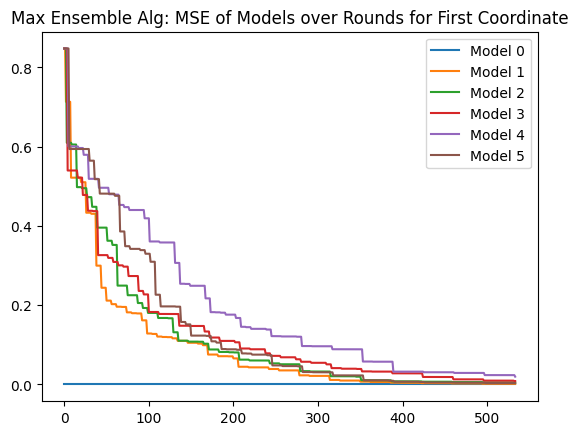

In [11]:
preds = np.array(maxModel.predictions_by_round)

preds_by_model = [preds[:,i] for i in range(maxModel.n_models)]
mses_by_model = np.zeros((len(preds_by_model), len(preds), maxModel.pred_dim))
for i in range(maxModel.n_models):
    for j in range(len(preds_by_model[i])):
        mses_by_model[i][j] = mse(ys, preds_by_model[i][j], multioutput='raw_values')

coord = 0
for i in range(maxModel.n_models):
    plt.plot(np.arange(len(maxModel.predictions_by_round)), mses_by_model[i][:,coord], label=f"Model {i}")
plt.legend()
plt.title("Max Ensemble Alg: MSE of Models over Rounds for First Coordinate");

Note: In the above MSE plot, we see that model 0 has completely flat MSE. This is because it's looking at MSE of only the first coordinate, which stays unchanged as it is a perfect predictor in the first coordinate. However, in the other coordinates, it *is* changing. As a result, the policy induced by its predictions changes every round, and so in the following plot, its revenue changes over the rounds of debiasing.

Text(0.5, 1.0, 'Max Ensemble Alg: Average Predicted and Realized Revenue of Policies')

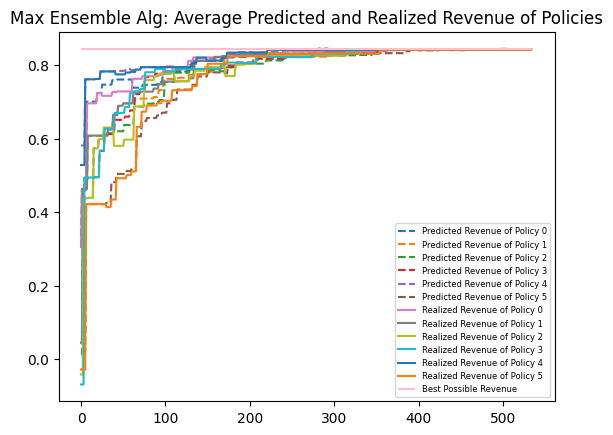

In [12]:
pred_rev = [[np.mean(np.einsum('ij, ij->i', preds_by_model[i][j], maxModel.policies[i].run_given_preds(preds_by_model[i][j]))) for j in range(len(preds_by_model[i]))] for i in range(maxModel.n_models)]
realized_rev = [[np.mean(np.einsum('ij, ij->i', ys, maxModel.policies[i].run_given_preds(preds_by_model[i][j]))) for j in range(len(preds_by_model[i]))] for i in range(maxModel.n_models)]

n = len(maxModel.predictions_by_round)
for i in range(maxModel.n_models):
    plt.plot(np.arange(n), pred_rev[i], '--', label=f"Predicted Revenue of Policy {i}")
for i in range(maxModel.n_models):
    plt.plot(np.arange(n), realized_rev[i], label=f"Realized Revenue of Policy {i}")

plt.hlines(np.mean(np.einsum('ij, ij->i', ys, maxModel.policies[0].run_given_preds(ys))), 0, n, label="Best Possible Revenue", color='pink')
plt.legend(prop={'size': 6})
plt.title("Max Ensemble Alg: Average Predicted and Realized Revenue of Policies")

Now, looking at the actual ensemble method that chooses the max self-assessed revenue from each of the input models, across rounds of updates.

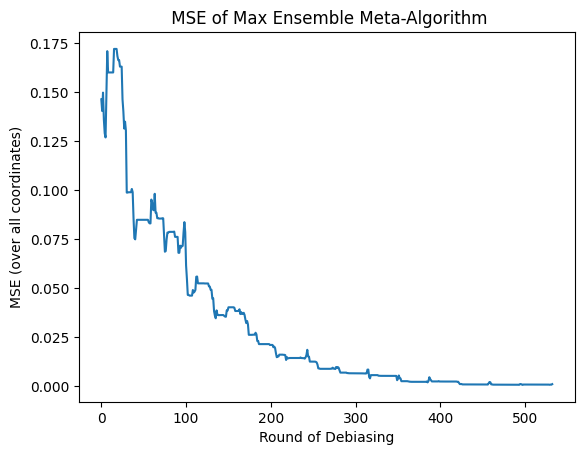

In [13]:
# mse in first coordinate

ensemble_mse = np.array([mse(ys, maxModel.meta_model_pred_by_round[i]) for i in range(len(maxModel.meta_model_pred_by_round))])
coord = 0

plt.plot(np.arange(len(ensemble_mse)), ensemble_mse)
plt.title(" MSE of Max Ensemble Meta-Algorithm")
plt.xlabel("Round of Debiasing")
plt.ylabel("MSE (over all coordinates)")
plt.savefig('meta-algMSE.png')
 

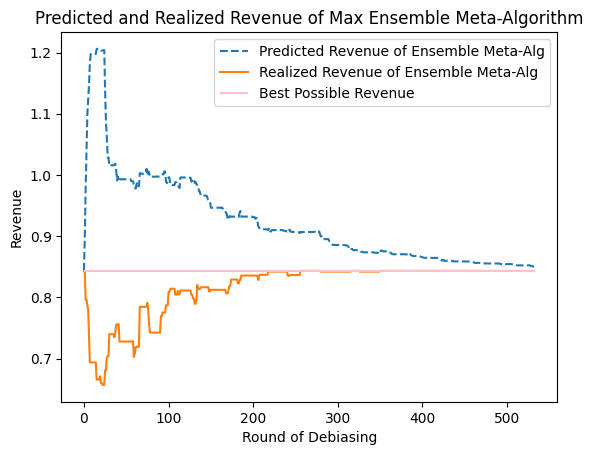

In [14]:
# Expected Revenue

pred_rev = [np.mean(np.einsum('ij, ij->i', maxModel.meta_model_pred_by_round[i], maxModel.meta_policy_choice_by_round[i])) for i in range(len(maxModel.meta_model_pred_by_round))]
realized_rev = [np.mean(np.einsum('ij, ij->i', ys, maxModel.meta_policy_choice_by_round[i])) for i in range(len(maxModel.meta_model_pred_by_round))] 

plt.plot(np.arange(len(maxModel.meta_model_pred_by_round)), pred_rev, '--', label="Predicted Revenue of Ensemble Meta-Alg")
plt.plot(np.arange(len(maxModel.meta_model_pred_by_round)), realized_rev, label="Realized Revenue of Ensemble Meta-Alg")
plt.hlines(np.mean(np.einsum('ij, ij->i', ys, maxModel.policies[0].run_given_preds(ys))), 0, len(maxModel.bias_array), label="Best Possible Revenue", color='pink')
plt.legend()
plt.title("Predicted and Realized Revenue of Max Ensemble Meta-Algorithm");
plt.xlabel("Round of Debiasing")
plt.ylabel("Revenue")
plt.savefig("meta-algRev.png")

# Comparison of two methods

Is the realized revenue of the two approaches appreciably different?

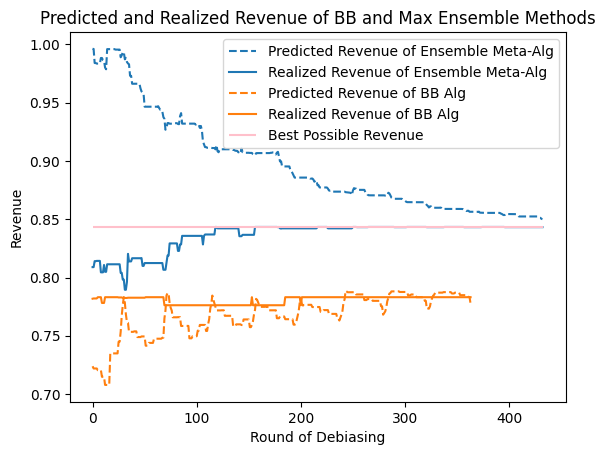

In [17]:
# Revenue of the max-ensemble model
max_ensemble_pred_rev = [np.mean(np.einsum('ij, ij->i', maxModel.meta_model_pred_by_round[i], maxModel.meta_policy_choice_by_round[i])) for i in range(len(maxModel.meta_model_pred_by_round))]
max_ensemble_realized_rev = [np.mean(np.einsum('ij, ij->i', ys, maxModel.meta_policy_choice_by_round[i])) for i in range(len(maxModel.meta_model_pred_by_round))] 

# Revenue of the bias-bounties model
bb_pred_rev = [np.mean(np.einsum('ij,ij->i', bbModel.predictions_by_round[i], init_policy.run_given_preds(bbModel.predictions_by_round[i]))) for i in range(len(bbModel.predictions_by_round))] #fancy vectorized row-wise dot product 
bb_true_rev = [np.mean(np.einsum('ij,ij->i', ys, init_policy.run_given_preds(bbModel.predictions_by_round[i]))) for i in range(len(bbModel.predictions_by_round))]

colors = list(mcolors.TABLEAU_COLORS)

start = 100
plt.plot(np.arange(len(max_ensemble_pred_rev)-start), max_ensemble_pred_rev[start:], '--', label="Predicted Revenue of Ensemble Meta-Alg", c=colors[0])
plt.plot(np.arange(len(max_ensemble_realized_rev)-start), max_ensemble_realized_rev[start:], label="Realized Revenue of Ensemble Meta-Alg", c=colors[0])
plt.plot(np.arange(len(bb_pred_rev)-start), bb_pred_rev[start:], '--', label="Predicted Revenue of BB Alg", c=colors[1])
plt.plot(np.arange(len(bb_true_rev)-start), bb_true_rev[start:], label="Realized Revenue of BB Alg", c=colors[1])
plt.hlines(np.mean(np.einsum('ij, ij->i', ys, maxModel.policies[0].run_given_preds(ys))), 0, len(maxModel.bias_array)-start, label="Best Possible Revenue", color='pink')
plt.legend()
plt.xlabel("Round of Debiasing")
plt.ylabel("Revenue")
plt.title("Predicted and Realized Revenue of BB and Max Ensemble Methods");
plt.savefig("Model-comparison.png")

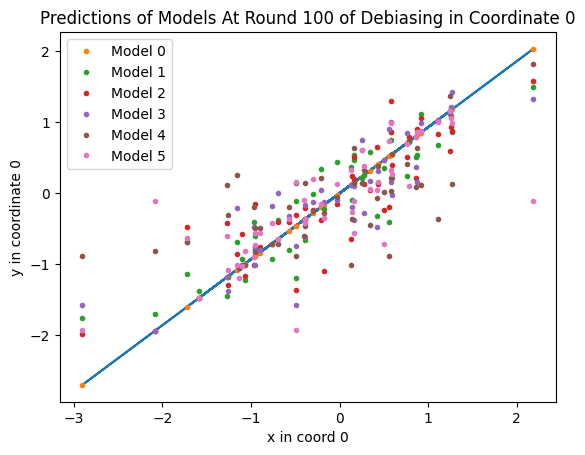

In [36]:
t = 100
coord = 0
plt.plot(xs[:,coord], ys[:,coord])
for model_index in range(maxModel.n_models):
    plt.plot(xs[:,coord], maxModel.predictions_by_round[t][model_index][:,coord], '.', label=f"Model {model_index}")
plt.legend()
plt.xlabel(f"x in coord {coord}")
plt.ylabel(f"y in coordinate {coord}")
plt.title(f"Predictions of Models At Round {t} of Debiasing in Coordinate {coord}");
plt.savefig("preds-at-round-100.png")

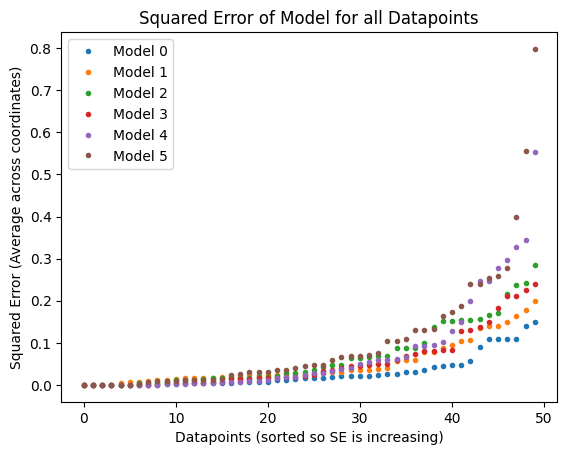

In [70]:
# squared error of models on each data point
for model_index in range(maxModel.n_models):
    plt.plot(np.arange(len(xs)), np.sort(np.mean([(maxModel.predictions_by_round[t][model_index][:,coord]-ys[:,coord])**2 for coord in range(maxModel.pred_dim)], axis=0)), '.', label=f"Model {model_index}")
plt.legend()
plt.ylabel("Squared Error (Average across coordinates)")
plt.xlabel("Datapoints (sorted so SE is increasing)")
plt.title("Squared Error of Model for all Datapoints")
plt.savefig("round-100-se.png")

# Variance Constrained Policy Testing

In [71]:
n = 50
n_features = 6
pred_dim = 6

np.random.seed(30)

# Gaussian xs, with true labels having a different linear relationship with xs in each coordinate
xs = np.random.normal(size=(n, n_features))
slopes = np.random.uniform(size = n_features)
#errs = np.random.normal(scale=0.01, size = (n, n_features))
ys = np.multiply(xs, slopes) #+ errs

def meta_model(coord, slopes):
    def model(xs):
        preds = np.random.normal(size=(n, pred_dim))
        true_ys = np.multiply(xs, slopes)
        preds[:,coord] = true_ys[:,coord]
        return preds
    return model

model = meta_model(0, slopes)

importlib.reload(policies)
alpha = 0.5
policy = policies.VarianceConstrained(pred_dim, model, 0.1, alpha, ys)
out = policy.run_given_preds(ys)

/opt/anaconda3/envs/bb-portfolio/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [69]:
out

array([[-3.56096161e-11,  7.92948284e-12,  5.46953295e-11,
         1.00000000e+00,  3.57434815e-11,  3.76119419e-11],
       [-1.12301536e-12,  3.00033748e-01,  5.07200423e-11,
         5.66760712e-12,  6.99966251e-01,  4.67575580e-11],
       [-1.33751565e-11,  1.57964496e-11, -2.41435874e-12,
         1.00000000e+00,  2.27762382e-12,  1.15551190e-11],
       [-5.50824146e-11,  6.87246944e-10,  6.99209457e-11,
         1.83253272e-10,  6.17781424e-11,  9.99999998e-01],
       [-7.81532510e-12,  2.62330915e-10,  2.99122747e-01,
         3.90817603e-11,  7.00877252e-01,  7.20737562e-11],
       [-2.55596346e-11,  3.66679353e-12,  9.99999998e-01,
         2.09990898e-11, -6.20617568e-12,  5.16110516e-11],
       [ 3.53783837e-01, -3.75540950e-11, -3.70007644e-11,
        -2.49111129e-11,  6.46216163e-01, -3.67861329e-11],
       [ 4.71370111e-11,  4.58492225e-11,  3.46445933e-11,
         2.98306045e-01,  7.01693954e-01,  3.87367252e-11],
       [ 3.58737990e-12,  2.48887665e-11,  4.201

Sanity check: 

1. It seems like the "sum to 1" condition isn't actually being satisfied. What's going on?

In [63]:
# for some reason some of the time, constraint is being violated. 
print(np.sum(out, axis=1))

flag = np.isclose(np.sum(out, axis=1), np.ones(50), atol=1e-4)
flag.shape

np.sum(out, axis=1)[[10,27, 38]]


[1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99999999e-01
 1.00000000e+00 9.99999998e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.99999999e-01 2.43731740e-09 9.99999997e-01
 1.00000000e+00 9.99999999e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99999999e-01
 9.99999998e-01 1.00000000e+00 9.99999999e-01 9.99999999e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 6.99446838e-01
 1.00000000e+00 1.00000000e+00 9.99999999e-01 9.99999999e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.99999999e-01 4.56332668e-09 1.00000000e+00
 1.00000000e+00 9.99999986e-01 9.99999999e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.99999000e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


array([2.43731740e-09, 6.99446838e-01, 4.56332668e-09])

In [61]:
flag

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [62]:
np.round(out[[10,27, 38]],3)

array([[-0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.699,  0.   ],
       [-0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

2. Are the variance conditions being satisfied?

In [67]:
from sklearn.covariance import empirical_covariance
cov = empirical_covariance(ys, assume_centered=False)

viol = np.zeros(len(out))
for i in range(len(out)):
    viol[i] = np.matmul(np.matmul(out[i], cov), np.transpose(out[i]))

print(f"Max violation: {alpha}")
print(f"Variance constraint of policy for each datapoint: \n {viol}")
print(f"Number of variance constraints which violate the max allowed variance: {sum(viol > alpha+0.001)}")

np.round(viol, 2)

Max violation: 0.5
Variance constraint of policy for each datapoint: 
 [1.09129128e-01 5.00000000e-01 1.09129128e-01 3.13415176e-03
 5.00000000e-01 1.79194875e-03 4.99999998e-01 5.00000000e-01
 5.00000000e-01 5.00000001e-01 1.08558548e-20 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 1.09129128e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 1.09129128e-01 5.00000000e-01 5.00000001e-01
 3.13415176e-03 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 1.09129128e-01 5.00000000e-01 5.00000000e-01
 1.04122387e-03 5.00000000e-01 6.21221982e-19 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 1.09129128e-01
 5.00000000e-01 5.00000000e-01 3.13414551e-03 5.00000000e-01
 1.09129128e-01 1.09129128e-01]
Number of variance constraints which violate the max allowed variance: 0


array([0.11, 0.5 , 0.11, 0.  , 0.5 , 0.  , 0.5 , 0.5 , 0.5 , 0.5 , 0.  ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.11, 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.11, 0.5 , 0.5 , 0.  , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.11, 0.5 , 0.5 , 0.  , 0.5 , 0.  , 0.5 , 0.5 , 0.5 , 0.5 , 0.11,
       0.5 , 0.5 , 0.  , 0.5 , 0.11, 0.11])

Also, there's weird things like this negative 0? Idk if this has to do with rounding or what.

In [28]:
out[0]



array([-0.,  0.,  0.,  1.,  0.,  0.])

Is the covariance matrix actually giving the variance of each coordinate along the diagonal? The original xs have variance 1 in each coordinate. The ys are just scaled versions of the coordinates of the xs. (Note: currently each coordinate of y is only a function of that coordinate of x. If I want actual correlation between the coordinates, I'll need to change this.) 

So, the variance of ys should be (slope)^2 * Var(x) = (slope)^2, and the diagonal of the empirical covariance matrix should be approximately equal to this.

In [31]:
print(f"Variances of each coordinate of the ys: \n {slopes**2}")

print(f"Diagonal of the covariance matrix: \n {np.diagonal(cov)}")

Variances of each coordinate of the ys: 
 [8.63475912e-01 8.53471298e-04 2.42160012e-03 1.17197999e-01
 9.83770484e-01 3.34773845e-03]
Diagonal of the covariance matrix: 
 [0.82798883 0.00104122 0.00179195 0.10912913 1.02202326 0.00313415]


# Experiment Pipeline Assuming the Policy Code Works

In [50]:
importlib.reload(policies)

n = 50
n_features = 6
pred_dim = 6

np.random.seed(30)

# Gaussian xs, with true labels having a different linear relationship with xs in each coordinate
xs = np.random.normal(size=(n, n_features))
slopes = np.random.uniform(size = n_features)
#errs = np.random.normal(scale=0.01, size = (n, n_features))
ys = np.multiply(xs, slopes) #+ errs

# series of models which each predict the correct linear relationship in one coordinate and random values elsewhere

def meta_model(coord, slopes):
    def model(xs):
        preds = np.random.normal(size=(n, pred_dim))
        true_ys = np.multiply(xs, slopes)
        preds[:,coord] = true_ys[:,coord]
        return preds
    return model

n_models = 6
gran = 0.1
var_limit = 0.1
all_models = []
all_policies = []

importlib.reload(policies)
policy = policies.VarianceConstrained(pred_dim, model, 0.1, 0.5, ys)
out = policy.run_given_preds(ys)


#policy.run_given_preds(ys)

for i in range(n_models):
    model = meta_model(i, slopes)
    all_models.append(model)
    all_policies.append(policies.VarianceConstrained(pred_dim, model, gran, var_limit, ys))

# model which predicts 0 everywhere
def init_model(xs):
    preds = np.zeros((len(xs), n_features), dtype='float64')
    return preds

init_policy = policies.VarianceConstrained(pred_dim, model, gran, var_limit, ys)

/opt/anaconda3/envs/bb-portfolio/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [53]:
max_depth = 400
tolerance = 0.01

bbModel = bbDebias.bbDebias(init_model, init_policy, xs, ys, max_depth, tolerance)
bbModel.debias(all_models, all_policies)

Maximum depth reached.


In [55]:
importlib.reload(maxDebias)
max_depth = 400
maxModel = maxDebias.EnsembledModel(all_models, all_policies, xs, ys, max_depth, tolerance)
maxModel.debias()

KeyboardInterrupt: 

In [ ]:
# Revenue of the max-ensemble model
max_ensemble_pred_rev = [np.mean(np.einsum('ij, ij->i', maxModel.meta_model_pred_by_round[i], maxModel.meta_policy_choice_by_round[i])) for i in range(len(maxModel.meta_model_pred_by_round))]
max_ensemble_realized_rev = [np.mean(np.einsum('ij, ij->i', ys, maxModel.meta_policy_choice_by_round[i])) for i in range(len(maxModel.meta_model_pred_by_round))] 

# Revenue of the bias-bounties model
bb_pred_rev = [np.mean(np.einsum('ij,ij->i', bbModel.predictions_by_round[i], init_policy.run_given_preds(bbModel.predictions_by_round[i]))) for i in range(len(bbModel.predictions_by_round))] #fancy vectorized row-wise dot product 
bb_true_rev = [np.mean(np.einsum('ij,ij->i', ys, init_policy.run_given_preds(bbModel.predictions_by_round[i]))) for i in range(len(bbModel.predictions_by_round))]

colors = list(mcolors.TABLEAU_COLORS)

start = 100
plt.plot(np.arange(len(max_ensemble_pred_rev)-start), max_ensemble_pred_rev[start:], '--', label="Predicted Revenue of Ensemble Meta-Alg", c=colors[0])
plt.plot(np.arange(len(max_ensemble_realized_rev)-start), max_ensemble_realized_rev[start:], label="Realized Revenue of Ensemble Meta-Alg", c=colors[0])
plt.plot(np.arange(len(bb_pred_rev)-start), bb_pred_rev[start:], '--', label="Predicted Revenue of BB Alg", c=colors[1])
plt.plot(np.arange(len(bb_true_rev)-start), bb_true_rev[start:], label="Realized Revenue of BB Alg", c=colors[1])
plt.hlines(np.mean(np.einsum('ij, ij->i', ys, maxModel.policies[0].run_given_preds(ys))), 0, len(maxModel.bias_array)-start, label="Best Possible Revenue", color='pink')
plt.legend()
plt.xlabel("Round of Debiasing")
plt.ylabel("Revenue")
plt.title("Predicted and Realized Revenue of BB and Max Ensemble Methods");
plt.savefig("Model-comparison.png")